In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
# mu, sigma = 37.25, 0.875 # mean and standard deviation
# np.clip(np.random.normal(mu, sigma,5), 35,40)
np.random.uniform(35,40,5)

array([38.78002465, 36.35630119, 35.90447712, 36.55008614, 39.14782054])

In [2]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([28.39548698, 27.20325227, 23.02636959, 20.02692516])
amb_dis = np.array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_shifttemp(ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return ans - 6.740361118467977

In [4]:
((40 + get_shifttemp(27.44472821,4)) + (35 + get_shifttemp(18.32839891,1)))/2 

28.62064660491722

In [5]:
(40 + get_shifttemp(27.44472821,4))

34.77061938132254

In [6]:
(35 + get_shifttemp(18.32839891,1))

22.4706738285119

In [7]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    print("interpolation complete")
    
    
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2))

    y_train[1] = (np.ones((dis,ln**2,16))*temp_inter).transpose(2,0,1)
    y_train[2] = (np.ones((16,ln**2,dis))*np.linspace(1,4,dis)).transpose(0,2,1)
    pos_x = np.array([np.linspace(1,6,6),]*6)
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,ln**2))*pos_x.reshape(-1))
    y_train[4] = (np.ones((16,dis,ln**2))*pos_y.reshape(-1))
    y_train = y_train.reshape(5,-1)
    print("y_train[1-4] complete")
    mu, sigma = 36.5, 0.875 # mean and standard deviation
    y_temp = np.clip(np.random.normal(mu, sigma,y_train.shape[1]), 36,40)
    y_amb = y_train[1]
    for i in range(y_train.shape[1]):
        _a = y_train[1,i]
        _b = y_train[2,i]
        y_train[0,i] = (y_temp[i] + get_shifttemp(_a,_b)-29)/7
#         y_train[0,i] = (36.5-37.5)/2.5
    y_train[1] = (y_train[1]/25) -1
    y_train = y_train.reshape(5,16,-1).transpose(2,1,0)
    print("y_train complete")
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
            for j in range(i+1,x_train.shape[0]):
                
                _a = random.randint(0,99)
                _b = random.randint(0,99)
                 #add noise
                mu, sigma = 0, 0.08 # mean and standard deviation
                _na = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
                _nb = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
                y_train2.append(y_train[i,k]+_na)
                y_train2.append(y_train[j,k]+_nb)
                y_train2.append(y_train[i,k]+_na)
                y_train2.append(y_train[j,k]+_nb)
                
                _x = np.zeros((2,8,8,1))
                _xo = np.zeros((2,8,8,1))
                _xo[0] = x_train[i,k,_a]
                _xo[1] = x_train[j,k,_b]
                _x[0] = np.clip((_xo[0]-y_amb[i]-0.5)/(30.5-y_amb[i]-0.5),0,1)
                _x[1] = np.clip((_xo[1]-y_amb[j]-0.5)/(30.5-y_amb[j]-0.5),0,1)
                _x[0] = np.maximum(_x[0]*(y_temp[i]-6) + (1-_x[0])*(y_amb[i]+0.5),_xo[0]) 
                _x[1] = np.maximum(_x[1]*(y_temp[j]-6) + (1-_x[1])*(y_amb[j]+0.5),_xo[1]) 
                _xx = np.amax(_x, axis = 0)
                x_train2.append(_xx)
                x_train2.append(_xx)
                x_train2.append(_x[0])
                x_train2.append(_x[1])
                
                
               
            
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train2[indices[:-ind]],y_train2[indices[:-ind],2:], y_train2[indices[:-ind],:2], x_train2[indices[-ind:-ind_half]], y_train2[indices[-ind:-ind_half],2:],y_train2[indices[-ind:-ind_half],:2], x_train2[indices[-ind_half:]], y_train2[indices[-ind_half:],2:], y_train2[indices[-ind_half:],:2]

In [8]:
x_train, x_train2, y_train, x_test, x_test2, y_test, x_val,x_val2, y_val = load_temperature()

print(x_train.shape)
print(x_train2.shape)
print(y_train.shape)

print(x_test.shape)
print(x_test2.shape)
print(y_test.shape)

print(x_val.shape)
print(x_val2.shape)
print(y_val.shape)

interpolation complete
y_train[1-4] complete
y_train complete
(8478720, 8, 8, 1)
(8478720, 3)
(8478720, 2)
(1059840, 8, 8, 1)
(1059840, 3)
(1059840, 2)
(1059840, 8, 8, 1)
(1059840, 3)
(1059840, 2)


In [62]:
y_train[:100]

array([[ 2.73296081e-01,  6.02765255e-02],
       [ 2.82095520e-01,  5.08983748e-02],
       [ 2.56657339e-01, -2.85798314e-02],
       [ 2.24699583e-01,  8.84109777e-02],
       [-4.74423809e-01, -2.43050663e-01],
       [ 4.18611914e-01,  8.84109777e-02],
       [ 5.23899951e-02,  7.90328270e-02],
       [-3.62447000e-01, -2.19237282e-01],
       [ 6.64721136e-02,  7.90328270e-02],
       [ 8.99627772e-02,  1.11592717e-02],
       [-2.45332821e-01, -2.43050663e-01],
       [ 8.59654467e-03, -1.71610521e-01],
       [ 2.39951179e-01,  1.11592717e-02],
       [-1.68990597e-01, -1.47797141e-01],
       [ 3.39274141e-01, -1.08058038e-01],
       [ 2.38965654e-01,  7.90328270e-02],
       [ 2.36419423e-01,  6.02765255e-02],
       [-4.90596529e-01, -2.43050663e-01],
       [ 1.19277480e-01,  5.08983748e-02],
       [ 2.66516030e-01,  8.84109777e-02],
       [-9.01491033e-02, -1.47797141e-01],
       [-3.50290940e-01, -2.43050663e-01],
       [ 4.71035898e-01, -2.85798314e-02],
       [-7.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 8, 8, 64)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

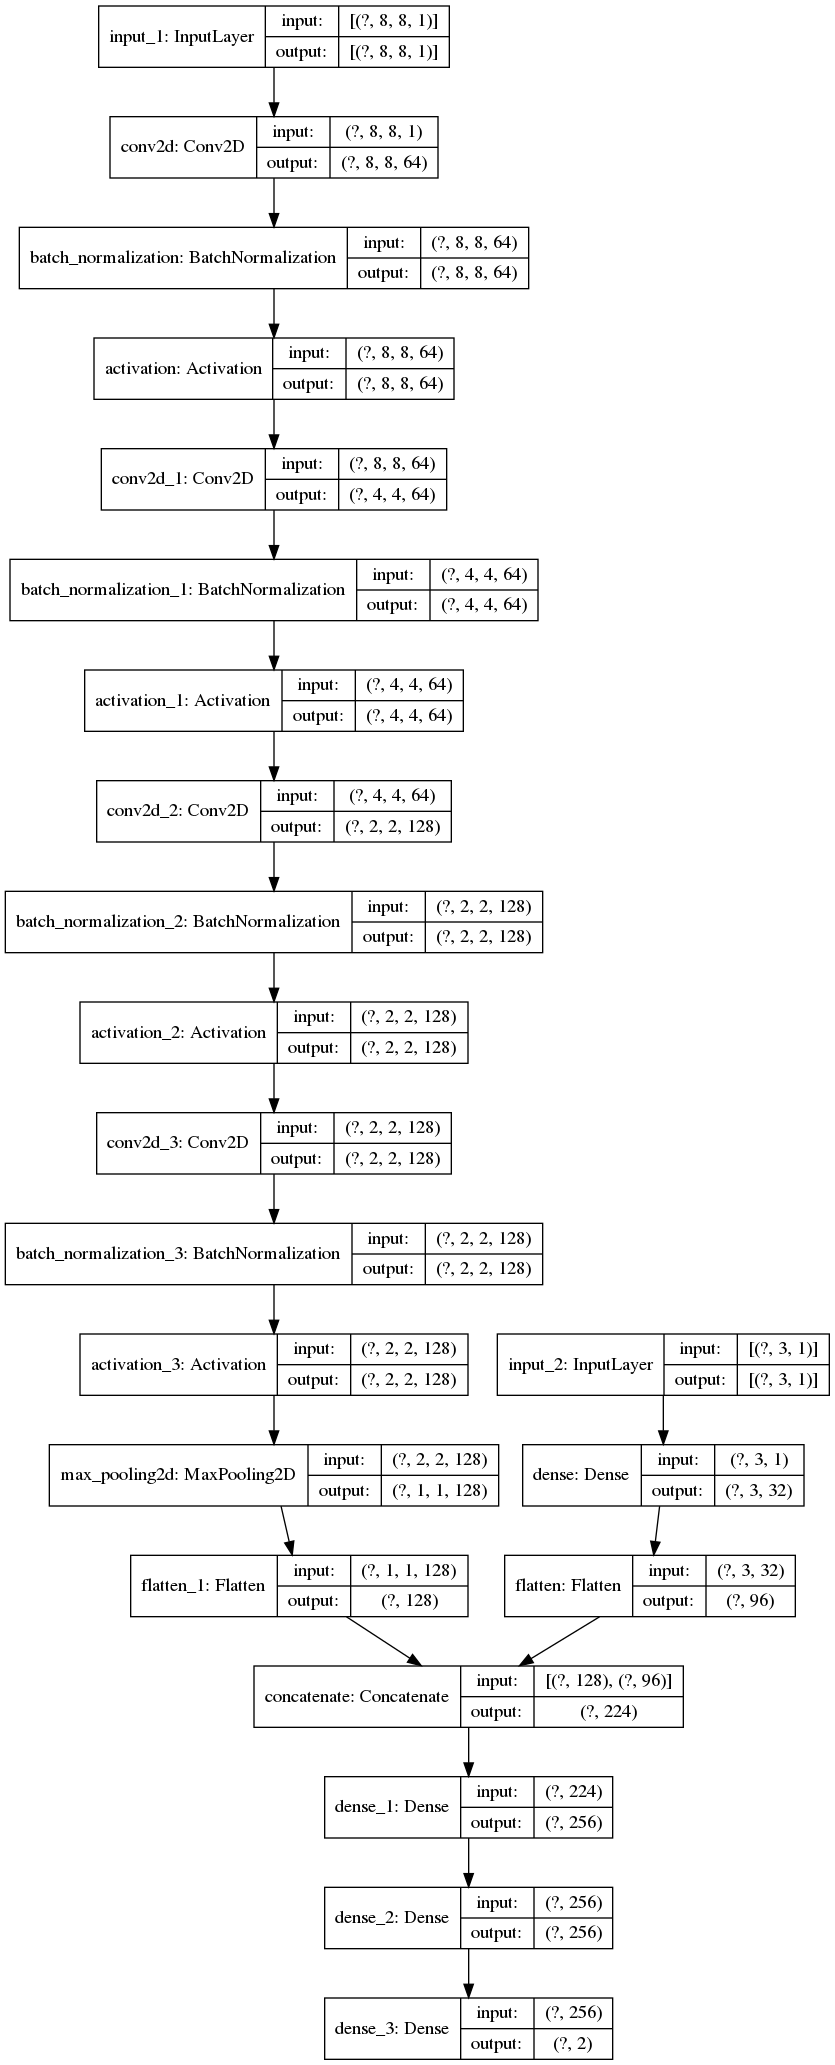

In [9]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.3
init = RandomNormal(stddev=0.02)

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)

# y2 = Dense(3, activation='relu')(inputs2)
# y2 = Reshape((3,3,1))(y2)
# y2 = Conv2DTranspose(1, (4,4), strides=(3,3), padding='same',output_padding = 2, kernel_initializer=init, activation = 'relu')(y2)
# y2 = Conv2D(filters=1,
#            kernel_size=kernel_size,
#           padding = 'same')(y2)
# y2 =Activation('relu')(y2)
# # y2 = BatchNormalization()(y2)
# # y2 =LeakyReLU(alpha=0.2)(y2)

# y = Concatenate()([inputs,y2])

# y = Dropout(0.2)(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          padding = 'same')(inputs)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
# y = MaxPooling2D()(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = MaxPooling2D()(y)

# y = Conv2D(filters=filters*4,
#            kernel_size=kernel_size)(y)
# y = BatchNormalization()(y)
# y =LeakyReLU(alpha=0.2)(y)
# y = MaxPooling2D()(y)
# y = Conv2D(filters=filters*4,
#            kernel_size=kernel_size,
#            activation='relu')(y)



# y = Dropout(dropout)(y)

y2 = Dense(32, activation='relu')(inputs2)
y2 = Flatten()(y2)
# y3 = Dense(filters*8, activation='relu')(y2)


# image to vector before connecting to dense layer
y = Flatten()(y)
y = Concatenate()([y,y2])
y = Dense(filters*4, activation='relu')(y)
y = Dense(filters*4, activation='relu')(y)
# y = Dense(filters*8, activation='relu')(y)
# dropout regularization
# y = Dropout(dropout)(y)
outputs = Dense(2, activation='tanh')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=[inputs,inputs2], outputs=[outputs])
# network model in text
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [10]:
opt = Adam(lr=0.0003, beta_1=0.9)
model.compile(loss='mae',
              optimizer= opt,
              metrics=['accuracy'])

batch_size = 256
history = model.fit([x_train,x_train2],
          y_train,
          validation_data=([x_test,x_test2], y_test),
          epochs=200,
          batch_size=batch_size)

score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
score = model.evaluate([x_val,x_val2], y_val, batch_size=batch_size)
print("\nValidation accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0389 - accuracy: 0.8529 - val_loss: 0.0437 - val_accuracy: 0.8471
Epoch 2/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0299 - accuracy: 0.8848 - val_loss: 0.0302 - val_accuracy: 0.8868
Epoch 3/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0261 - accuracy: 0.8982 - val_loss: 0.0352 - val_accuracy: 0.8747
Epoch 4/200
33120/33120 [==============================] - 104s 3ms/step - loss: 0.0241 - accuracy: 0.9050 - val_loss: 0.0321 - val_accuracy: 0.8836
Epoch 5/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0228 - accuracy: 0.9095 - val_loss: 0.0262 - val_accuracy: 0.8998
Epoch 6/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0219 - accuracy: 0.9125 - val_loss: 0.0242 - val_accuracy: 0.9050
Epoch 7/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0212 - accuracy: 0.9147

33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9337 - val_loss: 0.0176 - val_accuracy: 0.9261
Epoch 110/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9338 - val_loss: 0.0166 - val_accuracy: 0.9291
Epoch 111/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9339 - val_loss: 0.0161 - val_accuracy: 0.9309
Epoch 112/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9338 - val_loss: 0.0159 - val_accuracy: 0.9307
Epoch 113/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9340 - val_loss: 0.0169 - val_accuracy: 0.9279
Epoch 114/200
33120/33120 [==============================] - 105s 3ms/step - loss: 0.0153 - accuracy: 0.9340 - val_loss: 0.0170 - val_accuracy: 0.9273
Epoch 115/200
33120/33120 [==============================] - 104s 3ms/step - loss: 0.0153 - accuracy: 0.9340

In [33]:
x_train[0:10,:,:,0].round(2)

array([[[25.33, 26.09, 26.08, 26.54, 25.72, 25.92, 25.87, 25.91],
        [25.56, 26.22, 27.51, 28.12, 26.62, 25.82, 25.78, 25.14],
        [25.44, 26.45, 28.93, 29.67, 28.54, 26.59, 25.61, 25.1 ],
        [25.06, 25.81, 28.36, 29.21, 29.13, 27.7 , 24.68, 23.49],
        [25.02, 25.29, 27.29, 28.23, 28.89, 27.35, 23.31, 22.7 ],
        [25.02, 26.34, 27.17, 28.24, 28.17, 26.86, 24.7 , 23.69],
        [24.79, 26.94, 27.37, 27.64, 27.88, 27.36, 26.61, 23.51],
        [24.87, 25.95, 26.91, 27.47, 27.08, 26.29, 25.68, 23.89]],

       [[24.03, 24.58, 23.84, 24.23, 24.02, 23.85, 24.08, 23.35],
        [23.92, 23.7 , 23.67, 23.8 , 24.59, 25.38, 24.13, 23.26],
        [23.98, 23.38, 22.09, 23.49, 25.01, 26.  , 24.34, 23.59],
        [23.54, 22.47, 22.1 , 23.35, 25.12, 25.89, 24.07, 22.08],
        [23.2 , 22.46, 22.39, 23.99, 27.22, 26.98, 24.79, 22.43],
        [23.05, 22.06, 22.47, 24.71, 26.89, 26.76, 24.38, 22.86],
        [22.82, 22.51, 23.25, 25.8 , 27.18, 27.12, 26.28, 23.21],
        

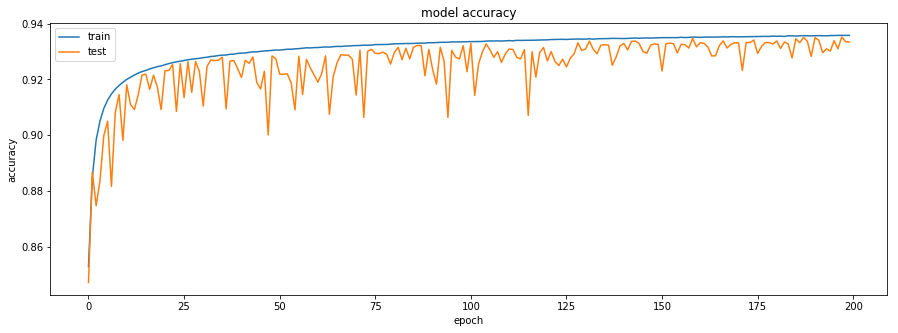

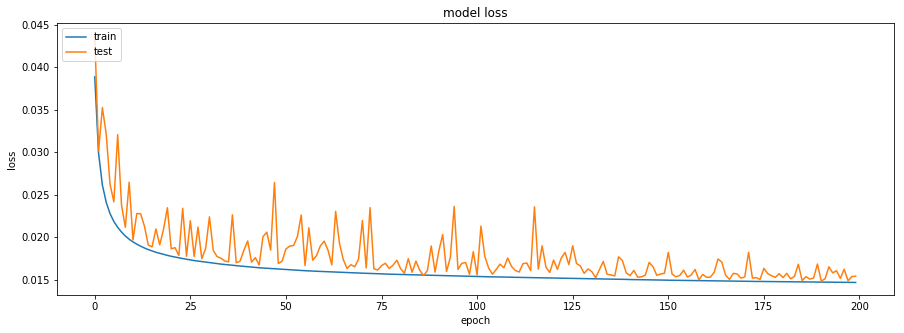

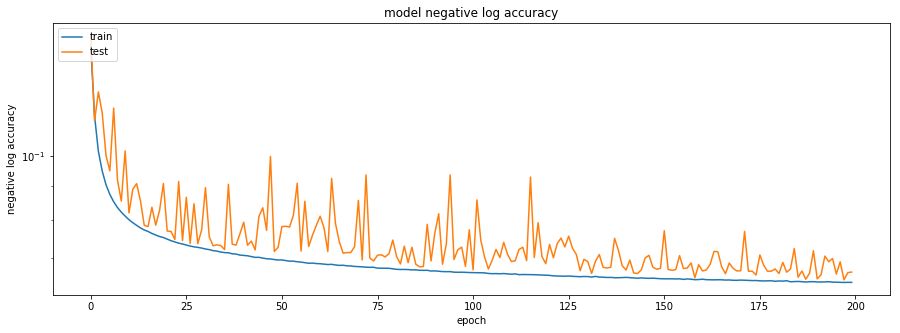

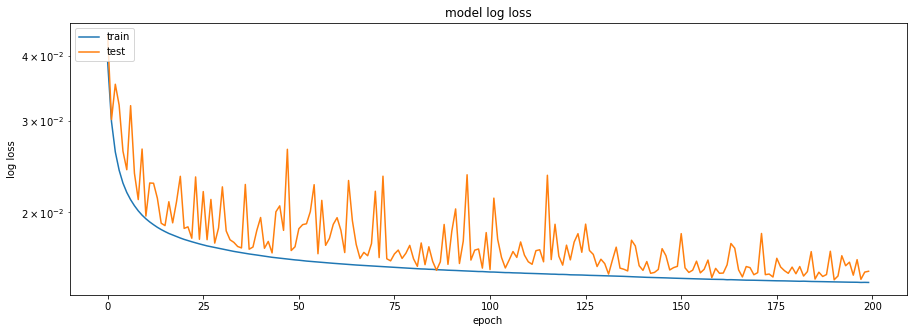

In [11]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#log

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(1-np.array(history.history['accuracy']))
plt.plot(1-np.array(history.history['val_accuracy']))
plt.title('model negative log accuracy')
plt.ylabel('negative log accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()
# summarize history for log loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model log loss')
plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [12]:
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.804515467387837).round(2)

In [13]:
for i in range(100):
    print(get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0]))

37.26
35.96
36.47
37.84
36.01
36.88
37.31
37.28
36.74
36.22
36.13
37.37
37.16
37.22
37.0
37.25
36.06
37.24
38.14
36.03
36.67
36.83
37.91
36.01
36.08
36.86
37.63
36.03
36.44
36.05
35.94
35.99
37.6
36.57
37.61
36.74
36.39
35.97
37.08
36.91
36.86
36.31
36.0
36.07
38.98
37.71
36.38
36.15
36.15
36.19
35.87
36.0
36.79
35.99
37.7
36.53
36.95
36.98
37.25
37.11
36.19
36.83
36.78
36.0
36.95
36.15
36.03
36.03
35.99
36.32
37.41
38.06
38.5
37.14
36.72
37.04
36.19
36.04
37.41
36.09
35.97
35.87
37.79
38.43
37.01
37.07
36.55
36.05
36.05
36.35
36.64
36.43
37.95
38.39
35.97
36.27
36.65
36.54
36.4
37.33


In [14]:
res = np.array(model.predict([x_test, x_test2])*np.array([7,25])+np.array([29,25]))

In [15]:
for i in range(100):
    print(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]))

36.65
36.58
36.71
37.84
35.94
36.57
37.15
37.28
36.84
36.06
36.13
37.02
36.2
37.23
36.84
37.31
36.0
37.11
38.19
35.97
36.59
36.87
36.6
36.51
36.05
36.88
37.33
36.02
36.44
36.76
36.35
36.09
37.47
36.51
37.64
36.77
36.39
36.93
36.85
36.91
36.84
36.42
35.97
37.0
36.59
37.76
36.38
36.14
36.3
36.43
36.28
35.99
36.3
36.03
37.54
36.61
36.9
36.81
37.12
37.1
37.01
36.91
36.77
35.9
36.91
36.07
36.04
36.0
36.44
36.42
37.56
38.12
36.88
37.14
36.74
37.01
36.2
35.96
36.65
36.51
36.13
35.85
37.93
38.29
37.01
37.07
36.46
37.52
36.04
36.41
36.66
36.49
37.99
36.77
35.98
36.59
36.29
36.6
36.38
37.27


In [24]:
for i in range(100):
    a = get_bodytemp(res[i,0],res[i,1],x_test2[i,0])
    b = get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0])
    if abs(a - b) >= 1:
        print([a,b,a - b])

[36.6, 37.91, -1.3099999999999952]
[36.59, 38.98, -2.3899999999999935]
[36.88, 38.5, -1.6199999999999974]
[37.52, 36.05, 1.470000000000006]
[36.77, 38.39, -1.6199999999999974]


In [17]:
model.save('newerer_model3.h5')

In [21]:
l = []
for i in range(100):
    l.append(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]) - get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0])))
np.median(np.array(l))

0.0799999999999983

In [23]:
l

[0.6099999999999994,
 0.6199999999999974,
 0.240000000000002,
 0.0,
 0.07000000000000028,
 0.3100000000000023,
 0.1600000000000037,
 0.0,
 0.10000000000000142,
 0.1599999999999966,
 0.0,
 0.3499999999999943,
 0.9599999999999937,
 0.00999999999999801,
 0.1599999999999966,
 0.060000000000002274,
 0.060000000000002274,
 0.13000000000000256,
 0.04999999999999716,
 0.060000000000002274,
 0.0799999999999983,
 0.03999999999999915,
 1.3099999999999952,
 0.5,
 0.030000000000001137,
 0.020000000000003126,
 0.30000000000000426,
 0.00999999999999801,
 0.0,
 0.7100000000000009,
 0.4100000000000037,
 0.10000000000000142,
 0.13000000000000256,
 0.060000000000002274,
 0.030000000000001137,
 0.030000000000001137,
 0.0,
 0.9600000000000009,
 0.22999999999999687,
 0.0,
 0.01999999999999602,
 0.10999999999999943,
 0.030000000000001137,
 0.9299999999999997,
 2.3899999999999935,
 0.04999999999999716,
 0.0,
 0.00999999999999801,
 0.14999999999999858,
 0.240000000000002,
 0.4100000000000037,
 0.00999999999999